# Exercise 4: Python Scripts, Concept of Grains, Display, Markdown,
* After cleaning and analyzing data, it's time to present the data in a beautifl fashion.
* At DDS, we often present our work directly in a Jupyter Notebook, which has many benefits such as.
    * We save the time it takes to copy and paste our graphs into a PowerPoint 
    * We ensure the accuracy of the data since we aren't manually retyping the data. 

In [1]:
import _starterkit_utils
import altair as alt
import numpy as np
import pandas as pd
from calitp_data_analysis import calitp_color_palette

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
FOLDER = "../starter_kit/"
FILE_NAME = "starter_kit_example_categorized.parquet"
category = pd.read_parquet(f"{FOLDER}{FILE_NAME}")

In [6]:
category.head(2)

ct_district                 project_name  \
0            1  Meadow Magic Multi-Use Path   
1            4     Bunny Hop Bike Boulevard   

                                                                                                                                                                           scope_of_work  \
0  a 2 mile class i bike lane and multi use path through a scenic meadow, featuring wildflower plantings, public art installations, and educational signage highlighting local wildlife.   
1          a class ii bike lane with charming streetlights, benches, and bike racks designed to resemble carrot sticks, connecting residential neighborhoods to local schools and parks.   

   project_cost                                lead_agency  \
0       5245734  Meadow Bunny Public Transportation (MBPT)   
1       6929368            Unicorn Fairy Express Bus (UFX)   

   accessibility_score  dac_accessibility_score  dac_traffic_impacts_score  \
0                    2                        8                          8   
1                    3                        9                          7   

   freight_efficiency_score  freight_sustainability_score  mode_shift_score  \
0                        10                             2                 3   
1                         6                             7                 6   

   lu_natural_resources_score  safety_score  vmt_score  zev_score  \
0                           5             3          2          7   
1                           3             2          2         10   

   public_engagement_score  climate_resilience_score  program_fit_score  \
0                        6                         6                 10   
1                        2                         6                  5   

   overall_score Transit ATP General_Lanes category  
0             72       N   Y             N      ATP  
1             68       N   Y             N      ATP

## Python Scripts
* Up until now, we have been placing all of our code in the Jupyter Notebook.
* While this is convenient, it's not the best practice. 
* A notebook full of code also isn't easy for viewers - it gets chaotic, quickly! 
* **The best solution is to move the bulk of your code when you have reached a stopping point to a Python Script.**
* Read all about the benefits of scripts [here in our DDS docs](https://docs.calitp.org/data-infra/analytics_tools/scripts.html). Summary points below: 
    * Summary points from the docs page above. What are Python scripts?
        * <i>Python scripts (.py) are plain text files. Git tracks plain text changes easily.</i>
        * <i>Scripts are robust to scaling and reproducing work.</i>
        * <i>Break out scripts by concepts / stages</i>
        * <i>All functions used in scripts should have docstrings. Type hints are encouraged!</i>
    * Which components should a script contain?
        * <i>1 script for importing external data and changing it from shapefile/geojson/csv to parquet/geoparquet
        * <i>If only using warehouse data or upstream warehouse data cached in GCS, can skip this first script
        * <i>At least 1 script for data processing to produce processed output for visualization
        * <i>Break out scripts by concepts / stages
        * <i>Include data catalog, README for the project
        * <i>All functions used in scripts should have docstrings. Type hints are encouraged!
### Sample Script 
* Making Python scripts is an art and not straight forward.
* I have already populated a `.py` file called `_starterkit_utils` with some sample functions.
* I imported my Python Script just like how I imported my other dependencies (Pandas, Altair, Numpy).

In [5]:
import _2024cathy04

### Breakdown of the Sample Script
#### Function 1
* You can also preview what a function does by writing `script_name.function_name??`
* Following what the DDS docs says, I am creating a new function every time I am processing the data in another stage.
* I have one function that loads in my dataset.

In [7]:
_2024cathy04.load_dataset??

Signature: _2024cathy04.load_dataset() -> pandas.core.frame.DataFrame
Source:   
def load_dataset()->pd.DataFrame:
    """
    Load the final dataframe.
    """
    FOLDER = "../starter_kit/"
    FILE_NAME = "starter_kit_example_categorized.parquet"
    
    # Read dataframe in
    df = pd.read_parquet(f"{FOLDER}{FILE_NAME}")
    
    # Capitalize the Scope of Work column again since it is all lowercase
    df.scope_of_work = df.scope_of_work.str.capitalize()
    
    # Clean up the column names
    df = reverse_snakecase(df)
    return df
File:      ~/data-analyses/starter_kit/_2024cathy04.py
Type:      function


* To use a function in a Script, write `name_of_your_script.name_of_the_function(whatever arguments)`
* Take a look at the column names: they are no longer in `snakecase` because I applied a function that capitalizes it properly.

In [8]:
category = _2024cathy04.load_dataset()

#### Function 2:
* After loading in the dataset from GCS, I am entering my second stage of processing the data.
* I am aggregating my dataframe by category. 

In [9]:
_2024cathy04.aggregate_by_category??

Signature: _2024cathy04.aggregate_by_category(df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
Source:   
def aggregate_by_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find the median overall score and project cost 
    and total unique projects by category.
    """
    agg1 = (
        df.groupby(["Category"])
        .aggregate(
            {
                "Overall Score": "median",
                "Project Cost": "median",
                "Project Name": "nunique",
            }
        )
        .reset_index()
        .rename(
            columns={
                "Overall Score": "Median Score",
                "Project Cost": "Median Project Cost",
                "Project Name": "Total Projects",
            }
        )
    )
    
    # Format the Cost column properly
    agg1['Median Project Cost'] = agg1['Median Project Cost'].apply(lambda x: '${:,.0f}'.format(x))
    
    return agg1
File:      ~/data-analyses/starter_kit/_2024cathy04.py
Type:     

In [10]:
aggregated_category = _starterkit_utils.aggregate_by_category(category)

In [11]:
aggregated_category

Category  Median Score Median Project Cost  Total Projects
0                    ATP         72.00          $4,991,255              11
1          General Lanes         73.00          $7,487,963               7
2  General Lanes and ATP         82.00          $5,672,550               2
3                  Other         73.00          $3,708,858              15
4                Transit         75.00          $4,399,886               8
5        Transit and ATP         75.00          $2,069,143               1

#### Function 3
* I want process my data a second way by changing it from wide to long. 
* [Read about wide to long.](https://www.statology.org/long-vs-wide-data/)
* [Pandas doc on melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html)

In [13]:
_2024cathy04.wide_to_long??

Signature: _2024cathy04.wide_to_long(df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
Source:   
def wide_to_long(df:pd.DataFrame)->pd.DataFrame:
    """
    Change the dataframe from wide to long based on the project name and
    Caltrans District.
    """
    df2 = pd.melt(
    df,
    id_vars=["Caltrans District","Project Name"],
    value_vars=[
        "Accessibility Score",
        "DAC Accessibility Score",
        "DAC Traffic Impacts Score",
        "Freight Efficiency Score",
        "Freight Sustainability Score",
        "Mode Shift Score",
        "Landuse Natural Resources Score",
        "Safety Score",
        "VMT Score",
        "ZEV Score",
        "Public Engagement Score",
        "Climate Resilience Score",
        "Program Fit Score",
    ])
    
    df2 = df2.rename(columns = {'variable':'Metric',
                                'value':'Score'})
    return df2
File:      ~/data-analyses/starter_kit/_2024cathy04.py
Type:      function

In [15]:
category2 = _2024cathy04.wide_to_long(category)

In [16]:
category2.head(2)

Caltrans District                 Project Name               Metric  Score
0                  1  Meadow Magic Multi-Use Path  Accessibility Score      2
1                  4     Bunny Hop Bike Boulevard  Accessibility Score      3

#### Function 4
* Now that I have my aggregated data, I want to visualize my results,
* `style_df` takes my pandas dataframe and makes it look a bit sleeker.

In [17]:
_2024cathy04.style_df(aggregated_category)

#### Function 5 
* After aggregating and reshaping the data, the next function presents the data.
* This is function that creates a chart that shows the scores by metric for each project.

In [18]:
_2024cathy04.create_metric_chart??

Signature: _2024cathy04.create_metric_chart(df: pandas.core.frame.DataFrame) -> altair.vegalite.v5.api.Chart
Source:   
def create_metric_chart(df: pd.DataFrame) -> alt.Chart:
    """
    Create a chart that displays metric scores
    for each project.
    """
    # Create dropdown
    metrics_list = df["Metric"].unique().tolist()

    metrics_dropdown = alt.binding_select(
        options=metrics_list,
        name="Metrics: ",
    )
    # Column that controls the bar charts
    xcol_param = alt.selection_point(
        fields=["Metric"], value=metrics_list[0], bind=metrics_dropdown
    )

    chart = (
        alt.Chart(df, title="Metric by Categories")
        .mark_circle(size=200)
        .encode(
            x=alt.X("Score", scale=alt.Scale(domain=[0, 10])),
            y=alt.Y("Project Name"),
            color=alt.Color(
                "Score",
                scale=alt.Scale(
                    range=calitp_color_palette.CALITP_CATEGORY_BRIGHT_COLORS
                ),
     

In [19]:
_2024cathy04.create_metric_chart(category2)

alt.Chart(...)

## Grains
* This is a light introduction to the concept of grains.
* Grain means the level your dataset is presented at.
* Basically, what does each row represent?
* The original dataset is presented on the project-level grain because each row represents a unique project. 

In [20]:
category[["Project Name", "Overall Score"]].head()

Project Name  Overall Score
0       Meadow Magic Multi-Use Path             72
1          Bunny Hop Bike Boulevard             68
2    Strawberry Shortcake Sidewalks             87
3         River Ramble Rabbit Trail             75
4  Lilac Lane Dream Complete Street             72

* If we aggregate the dataset using Caltrans District, then this dataset would be on the district gain.

In [21]:
category.groupby(["Caltrans District"]).agg({"Project Name": "nunique"}).reset_index().rename(
    columns={"Project Name": "Total Projects"}
)

Caltrans District  Total Projects
0                   1               1
1                   2               2
2                   3               6
3                   4               6
4                   5               4
5                   6               3
6                   7               3
7                   8               5
8                   9               3
9                  10               2
10                 11               5
11                 12               4

* If we aggregate the dataset by lead agency, then this dataset would be on the agency gain.

In [22]:
category.groupby(["Lead Agency"]).agg({"Project Name": "nunique"}).reset_index().rename(
    columns={"Project Name": "Total Projects"}
)

Lead Agency  Total Projects
0             Bunny's Meadow Hop Transportation (BMHT)               3
1                          Cherry Metro Services (CMS)               1
2                                 Dewdrop Ride Transit               2
3                 Elf's Efficient Transportation (EET)               3
4                    Fairy Creek Public Transit (FCPT)               5
5                        Gnome Valley Rail Link (GVRL)               3
6            Meadow Bunny Public Transportation (MBPT)               4
7                        Morning Dewdrop Transit (MDT)               4
8                 Mushroom Metro Transit Agency (MMTA)               5
9   Rainbow Mushroom Transportation Corporation (RMTC)               5
10              Shining Sparkle Transit Systems (SSTS)               4
11           Strawberry Rainbow Transit Systems (SRTS)               4
12                     Unicorn Fairy Express Bus (UFX)               1

* Grains can get very minute. The one below is Lead Agency and Category Grain. 

In [23]:
category.groupby(["Lead Agency", "Category"]).agg(
    {"Project Name": "nunique"}
).reset_index().rename(columns={"Project Name": "Total Projects"})

Lead Agency               Category  \
0             Bunny's Meadow Hop Transportation (BMHT)                  Other   
1             Bunny's Meadow Hop Transportation (BMHT)                Transit   
2                          Cherry Metro Services (CMS)                  Other   
3                                 Dewdrop Ride Transit                    ATP   
4                                 Dewdrop Ride Transit                  Other   
5                 Elf's Efficient Transportation (EET)                    ATP   
6                 Elf's Efficient Transportation (EET)          General Lanes   
7                 Elf's Efficient Transportation (EET)                Transit   
8                    Fairy Creek Public Transit (FCPT)                    ATP   
9                    Fairy Creek Public Transit (FCPT)                  Other   
10                   Fairy Creek Public Transit (FCPT)                Transit   
11                       Gnome Valley Rail Link (GVRL)                    ATP   
12                       Gnome Valley Rail Link (GVRL)                  Other   
13                       Gnome Valley Rail Link (GVRL)        Transit and ATP   
14           Meadow Bunny Public Transportation (MBPT)                    ATP   
15           Meadow Bunny Public Transportation (MBPT)  General Lanes and ATP   
16           Meadow Bunny Public Transportation (MBPT)                  Other   
17           Meadow Bunny Public Transportation (MBPT)                Transit   
18                       Morning Dewdrop Transit (MDT)          General Lanes   
19                       Morning Dewdrop Transit (MDT)                  Other   
20                       Morning Dewdrop Transit (MDT)                Transit   
21                Mushroom Metro Transit Agency (MMTA)          General Lanes   
22                Mushroom Metro Transit Agency (MMTA)                  Other   
23                Mushroom Metro Transit Agency (MMTA)                Transit   
24  Rainbow Mushroom Transportation Corporation (RMTC)                    ATP   
25  Rainbow Mushroom Transportation Corporation (RMTC)          General Lanes   
26  Rainbow Mushroom Transportation Corporation (RMTC)                  Other   
27  Rainbow Mushroom Transportation Corporation (RMTC)                Transit   
28              Shining Sparkle Transit Systems (SSTS)                    ATP   
29              Shining Sparkle Transit Systems (SSTS)          General Lanes   
30              Shining Sparkle Transit Systems (SSTS)  General Lanes and ATP   
31              Shining Sparkle Transit Systems (SSTS)                  Other   
32           Strawberry Rainbow Transit Systems (SRTS)                    ATP   
33           Strawberry Rainbow Transit Systems (SRTS)          General Lanes   
34           Strawberry Rainbow Transit Systems (SRTS)                  Other   
35                     Unicorn Fairy Express Bus (UFX)                    ATP   

    Total Projects  
0                2  
1                1  
2                1  
3                1  
4                1  
5                1  
6                1  
7                1  
8                1  
9                2  
10               2  
11               1  
12               1  
13               1  
14               1  
15               1  
16               1  
17               1  
18               2  
19               1  
20               1  
21               1  
22               3  
23               1  
24               2  
25               1  
26               1  
27               1  
28               1  
29               1  
30               1  
31               1  
32               2  
33               1  
34               1  
35               1

## Create your own Script
* **Make sure your functions make sense for the district grain. You will be using these functions for Exercise 5.**
* In your script, separate out functions by step like above. 
    * One function that loads the dataset and does some light cleaning.
    * One (or more) functions that transform your dataframe.
        * `melt()`, `.T`, `.groupby()` are just some of the many options available through `pandas`. 
    * One (or more) functions that visualize your dataframe.
        * Could be a chart, a styled dataframe, a wordcloud. 
* Other things to consider
    * Our [DDS Docs](https://docs.calitp.org/data-infra/publishing/sections/4_notebooks_styling.html#narrative) has a great guide on what "checkboxes" need to be "checked" when presenting data. The first 3 sections are the most relevant.
    * To summarize the docs, double check:
        * Are currency columns formatted with $ and commas?
        * Are all the scores formatted with the same number of decimals?
        * Are the string columns formatted with the right punctuation and capitalization?
        * Are the column names formatted properly? While `snake_case` is very handy when we are analyzing the dataframe, it is not very nice when presenting the data. We typically reverse the `snake_case` back to something like `Project Name`.
        * [Caltrans Districts are currently integers, but they have actual names that can be mapped.](https://cwwp2.dot.ca.gov/documentation/district-map-county-chart.htm) 
   

## Markdown/Display
* Although our code is now neatly stored in a Python script, a Jupyter Notebook on its own is a bit plain, even when we have beautiful charts. 
* There are many ways to jazz it up.
* **Resource**: [Data Camp's Markdown Tutorial](https://www.datacamp.com/tutorial/markdown-in-jupyter-notebook)
### Images
#### In a Markdown Cell
* You can add an image in a markdown cell
`<img src="https://raw.githubusercontent.com/cal-itp/data-analyses/refs/heads/main/portfolio/Calitp_logo_MAIN.png" width=100 height=100 />`<p>
<img src="https://raw.githubusercontent.com/cal-itp/data-analyses/refs/heads/main/portfolio/Calitp_logo_MAIN.png" width=100 height=100 />
#### In a Code Cell
* You can add an image in a code cell if you import the packages below.

Try to add an image in markdown cell. See below:

<img src="https://raw.githubusercontent.com/cal-itp/data-analyses/refs/heads/main/portfolio/Calitp_logo_MAIN.png" width=100 height=100 />

In [24]:
from IPython.display import HTML, Image, Markdown, display, display_html

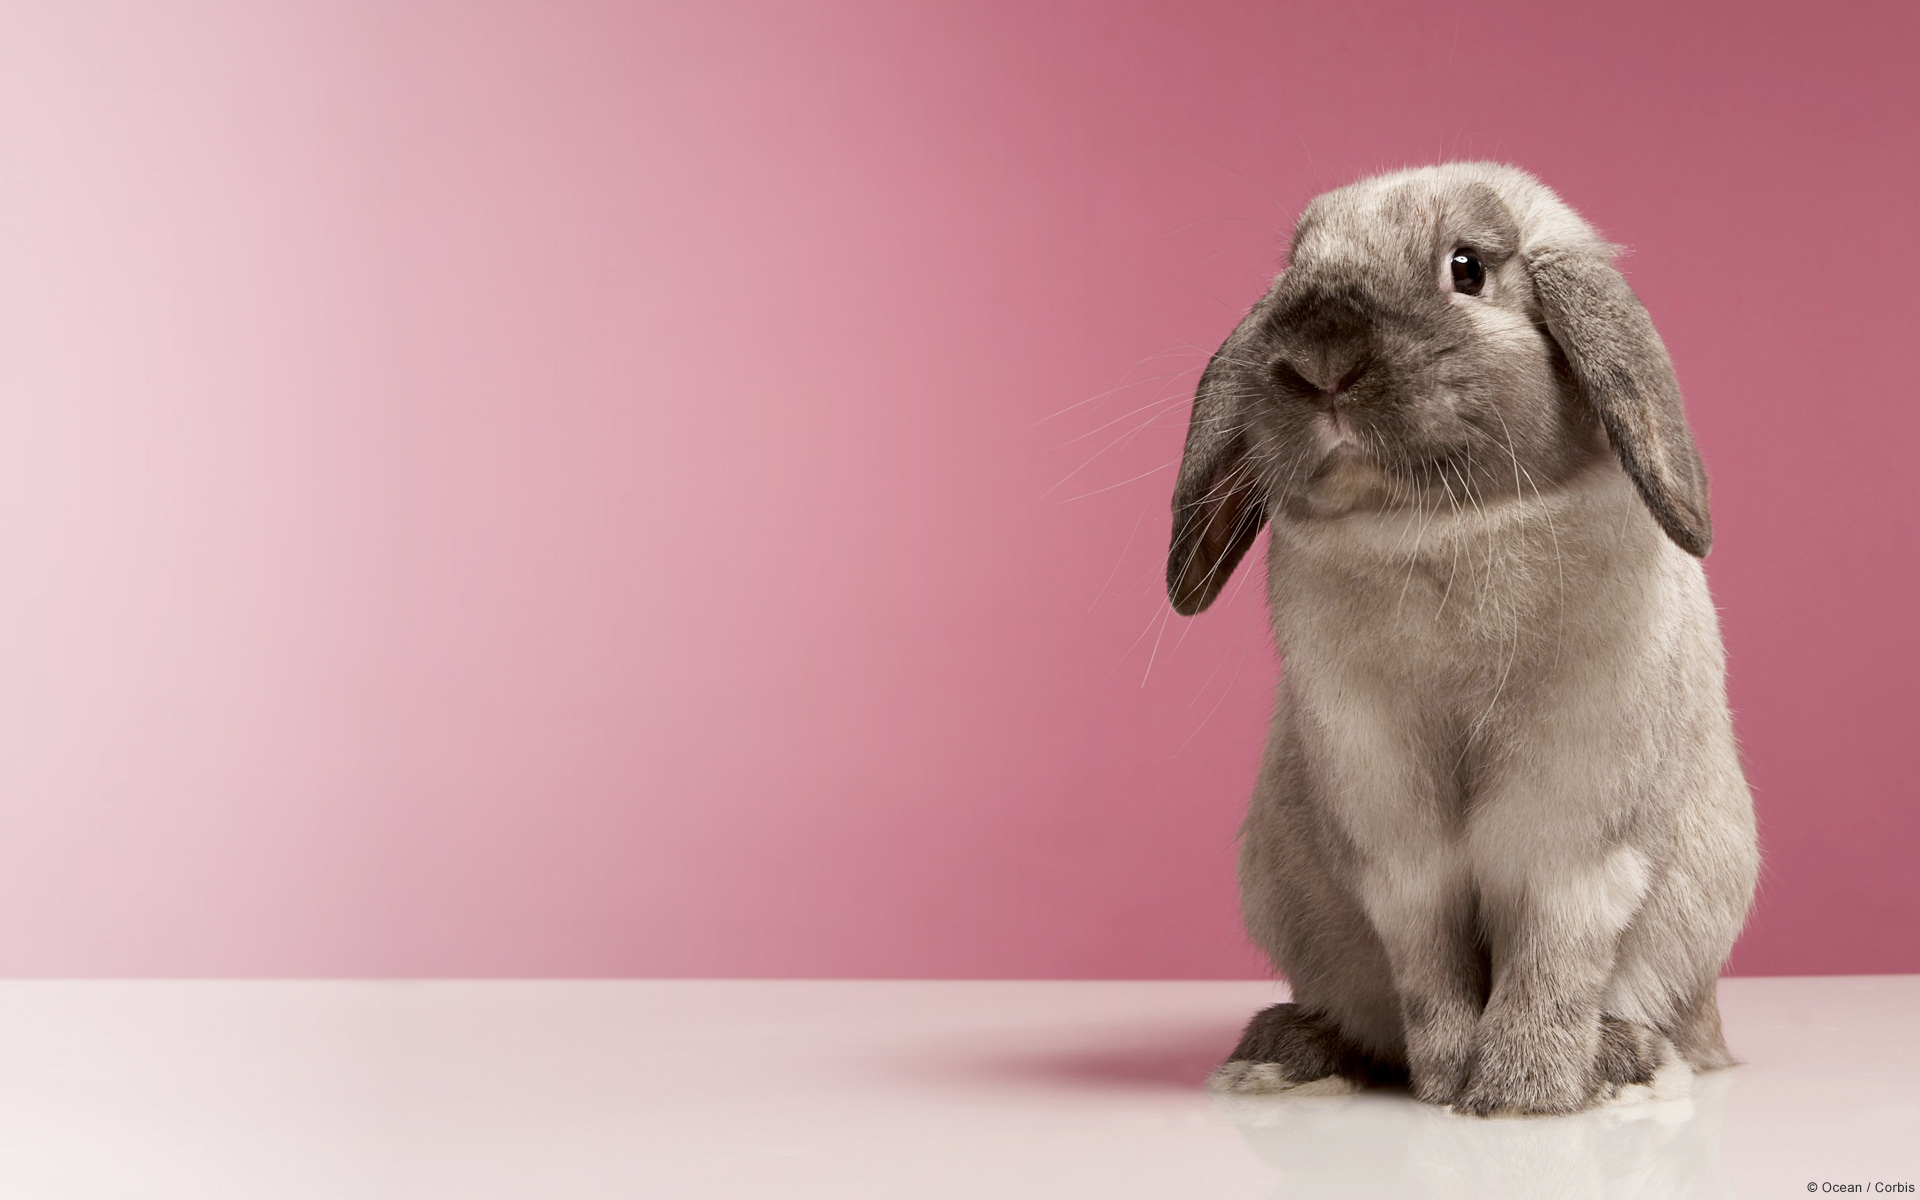

In [25]:
display(Image(filename="./19319_en_1.jpg", retina=True))

### Display
* Of course, you can write your narratives in a Markdown cell like what I'm doing right now.
* However, what if you want to incorporate values from your dataframe into the narrative?
* Writing out the values manually in markdown locks you in. If the values change, you'll have to rewrite your narrative which is timely and prone to inaccuracy.
* The best way is to use `display` and `markdown` from  `from IPython.display`
* We are using District 3 as an example

#### No hard coding
* Save out your desired value into a new variable whenever you want to reference it in a narrative.

In [26]:
# Filter for D3
d3 = category.loc[category["Caltrans District"] == 3].reset_index(drop=True)

In [27]:
# Find the median overall score
d3_median_score = d3["Overall Score"].median()

In [28]:
# Find total projects
d3_total_projects = d3["Project Name"].nunique()

In [29]:
# Find the most expensive project
d3_max_project = d3["Project Cost"].max()

In [30]:
# Format the cost so it's something like $1,000,000 instead of 1000000
d3_max_project = f"${d3_max_project:,.2f}"

#### Long F-String + Headers
* F-strings can have multiple quotation marks. This allows you to write a f-string that goes over multiple lines.
* `<h3>` and `</h3>` displays District 3 in a header. 
    * Headers vary in size, 1 being the largest. 
* `<b></b>` bolds the text. 
    * `<s></s>` strikes the text.
* Notice that you always have to **close** your HTML with `</whatever_you_are_doing>`

In [31]:
display(
    Markdown(
        f"""<h3>District 3</h3>
        The median score for projects in District 3 is <b>{d3_median_score}</b><br> 
        The total number of projects is <b>{d3_total_projects}</b><br>
        <s>The most expensive project costs</s> <b>{d3_max_project}</b>
        """
    )
)

<h3>District 3</h3>
        The median score for projects in District 3 is <b>80.5</b><br> 
        The total number of projects is <b>6</b><br>
        <s>The most expensive project costs</s> <b>$9,448,022.00</b>
        

#### You can code in this cell. I'm filtering out for district 3 values.
* Notice the header went from `<h3>` to `<h4>`. 

In [32]:
display(
    Markdown(
        f"""<h5>Metric Scores</h5>
        """
    )
)
display(_2024cathy04.create_metric_chart(category2))

<h5>Metric Scores</h5>
        

alt.Chart(...)

### `Markdown` and `Display` can be worked into functions 
* What if I wanted to generate these reports for every district?
* I can simply turn this into a function.

In [35]:
_2024cathy04.create_district_summary??

In [34]:
for district in range(10, 12):
    _2024cathy04.create_district_summary(category, district)

The median score for projects in District 10 is <b>72.5</b><br> 
        The total number of projects is <b>2</b><br>
        The most expensive project costs <b>$7,160,933.00</b>
        

<h4>Metrics aggregated by Categories</h4>
        

<h4>Overview of Projects</h4>
        

<h4>Metric Scores by Project</h4>
        

alt.Chart(...)

The median score for projects in District 11 is <b>75.0</b><br> 
        The total number of projects is <b>5</b><br>
        The most expensive project costs <b>$8,956,026.00</b>
        

<h4>Metrics aggregated by Categories</h4>
        

<h4>Overview of Projects</h4>
        

<h4>Metric Scores by Project</h4>
        

alt.Chart(...)

## Your turn to combine all your functions into one function
* Take some inspiration from ` _starterkit_utils.create_district_summary(df, district).`
* Incorporate concepts from `markdown` and `display` to create a polished report. 

In [38]:
display(
    Markdown(
        f"""<h2>Category Summary</h2>
        """
    )
)
display(_2024cathy04.aggregate_by_category(category))

<h2>Category Summary</h2>
        

Category  Median Score Median Project Cost  Total Projects
0                    ATP         72.00          $4,991,255              11
1          General Lanes         73.00          $7,487,963               7
2  General Lanes and ATP         82.00          $5,672,550               2
3                  Other         73.00          $3,708,858              15
4                Transit         75.00          $4,399,886               8
5        Transit and ATP         75.00          $2,069,143               1